# Xarray-spatial
### User Guide: Zonal
-----

[Generate terrain](#Generate-Terrain-Data)
[Zonal Statistics](#Zonal-Statistics)

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

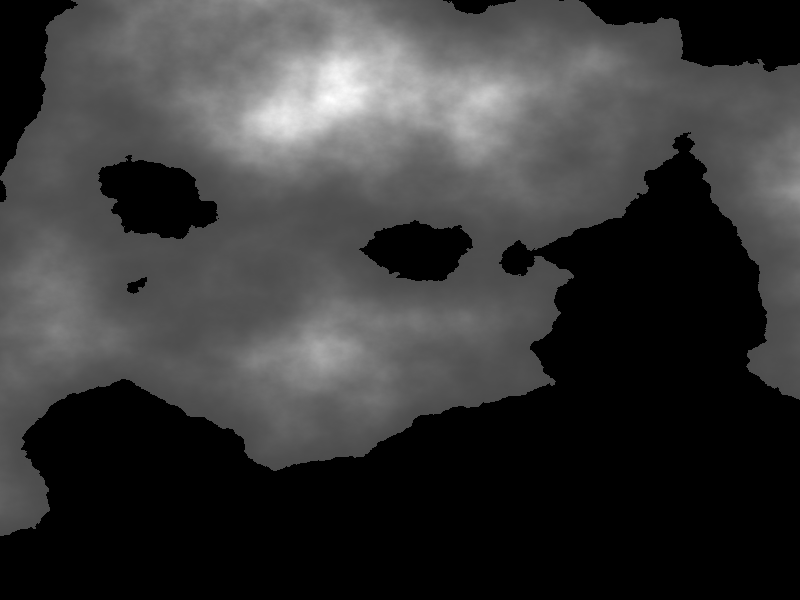

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale value above shows the elevation linearly in intensity (with the large black areas indicating low elevation), but it will look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops:

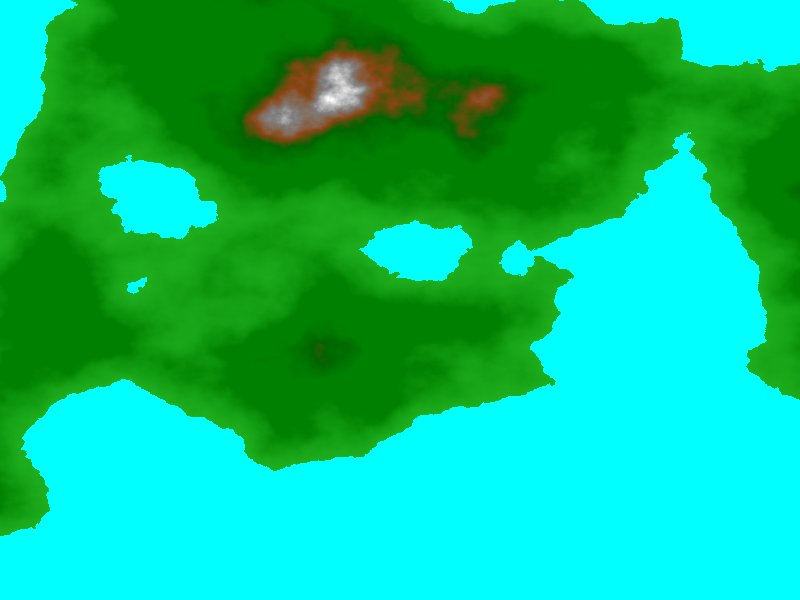

In [3]:
shade(terrain, cmap=Elevation, how='linear')

## Zonal Statistics

Zonal statistics allows for calculating summary statistics for specific areas or *zones* within a datashader aggregate. Zones are defined by creating an integer aggregate where the cell values are zone_ids.  The output of zonal statistics is a Pandas dataframe containing summary statistics for each zone based on a value raster.

Imagine the following scenario:
- You are a hiker on a six-day-trip.
- The path for each day is defined by a line segement.
- You wish to calculate the max and min elevations for each hiking segment as a Pandas dataframe based on an elevation dataset.

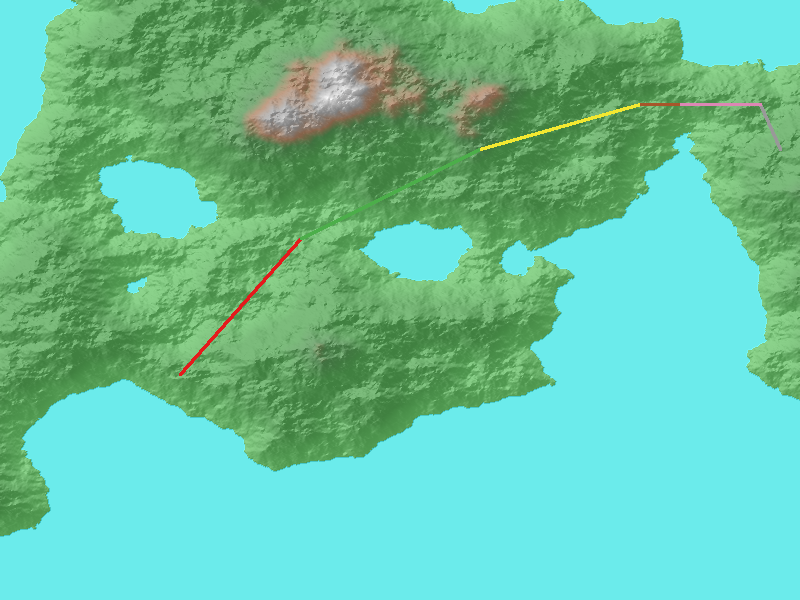

In [4]:
from xrspatial import hillshade
from datashader.colors import Set1
import pandas as pd

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

terrain = generate_terrain(canvas=cvs)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how='linear')

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=['gray', 'white'], alpha=255, how='linear')

zone_df = pd.DataFrame({
   'x': [-11, -5, 4, 12, 14, 18, 19],
   'y': [-5, 4, 10, 13, 13, 13, 10],
   'trail_segement_id': [11, 12, 13, 14, 15, 16, 17]
})

zones_agg = cvs.line(zone_df, 'x', 'y', ds.sum('trail_segement_id'))
zones_shaded = dynspread(shade(zones_agg, cmap=Set1), max_px=5)

stack(illuminated_shaded, terrain_shaded, zones_shaded)

In [5]:
from xrspatial import zonal_stats
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(np.int)
zonal_stats(zones_agg, terrain)

,mean,max,min,std,var,count
11,1321.919879,1428.384240,1228.065037,53.409131,2852.535316,136.0
12,1489.600166,2399.556289,1220.694206,310.177594,96210.140061,180.0
13,1711.632114,2430.430303,1368.922124,278.369664,77489.669636,160.0
14,1355.661087,1368.952389,1346.856316,6.249734,39.059170,40.0
15,1381.950485,1443.856734,1319.891060,38.918956,1514.685125,80.0
16,1486.314866,1709.222348,1367.673562,120.950684,14629.068060,45.0


##### Calculate custom stats for each zone

In [6]:
custom_stats = dict(elevation_change=lambda zone: zone.max() - zone.min(),
                    elevation_min=np.min,
                    elevation_max=np.max)

zonal_stats(zones_agg, terrain, custom_stats)

,elevation_change,elevation_min,elevation_max
11,200.319203,1228.065037,1428.384240
12,1178.862083,1220.694206,2399.556289
13,1061.508179,1368.922124,2430.430303
14,22.096073,1346.856316,1368.952389
15,123.965674,1319.891060,1443.856734
16,341.548786,1367.673562,1709.222348


Here the zones are defined by line segments, but they can be any spatial pattern, and in particular can be any region computable as a Datashader aggregate.